In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import xgboost as xgb
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 13

# Electric Motor Temperature Predictor


This notebook is a continuation of my series where I am working through the fastai [course](https://course.fast.ai/) and [book](https://github.com/fastai/fastbook). Much of my work in these notebooks will be to demonstrate the content presented and to build upon it. For this notebook, I will tackle the task of predicting the temperature of an electric motor given certain measurements such as the ambient temperature, coolant temperature, motor speed, and more. This dataset can be found on [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature) and I have already downloaded it, but if you wish to download it from kaggle in the notebook there is an api for that. Kaggle provides datasets, courses, forums, and competitions for data scientists and is a great resource for both amateur and experienced data scientists. In addition I would like to say thanks and acknowledgements to the Paderborn University Lab for providing this interesting dataset.

This dataset is in tabular format and the fastai library is unique because it is one of the few deep learning libraries which does provide easy to use abstraction methods to build neural networks for tabular data. While there is a lot of data that is in tabular format, many of the more traditional machine learning methods have done quite well and are still the default method used for classification/regression on tabular data. Some examples are [random forests](https://en.wikipedia.org/wiki/Random_forest) or [XGBoost](https://en.wikipedia.org/wiki/XGBoost). I will cover both more traditional methods and a neural network approach to solve this task and then contrast the two.

### Exploratory Data Analysis 

In [3]:
df = pd.read_csv('Data/pmsm_temperature_data.csv', low_memory=False)
df.columns

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
       'profile_id'],
      dtype='object')

Here I use the pandas library to read in the csv file and then to display the columns of the dataset. Each column has the following description from the Kaggle website.

- **ambient**: Ambient temperature as measured by a thermal sensor located closely to the stator.
- **coolant**: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
- **u_d**: Voltage d-component.
- **u_q**: Voltage q-component.
- **motor_speed**: The motor speed.
- **torque**: Torque induced by the current.
- **i_d**: Current d-component.
- **i_q**: Current q-component.
- **pm**: Permanent Magnet surface temperature representing the rotor temperature.
- **stator_yoke**: Stator yoke temperature measured with a thermal sensor.
- **stator_tooth**: Stator tooth temperature measured with a thermal sensor.
- **stator_winding**: Stator winding temperature measured with a thermal sensor.
- **profile_id**: Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other.

The descriptions for each of the variables are fairly self-explanatory. The cover temperatures and the amount of energy being supplied to the motor. The variables to predict are **pm, stator_yoke, stator_tooth,** and **stator_winding.** These four variables represent temperatures taken at four different parts of the motor and are the temperatures that should be predicted. The goal is then to predict those temperatures using the remaining variables all of which would seem to impact motor temp, but further exploration should and will be conducted. 

This task is a good example of a real-world problem one may want to solve using a machine learning model. Predicting temperature for car motors may provide increased safety or performance as it allows the car to adjust itself to maintain the highest performance and reliability possible. For example, given the predicted motor temperature is too high the car could increase coolant flow or reduce coolant temperature to keep the motor from overheating.

In [4]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [5]:
 df.isnull().values.any()

False

There do not appear to be any missing values so no changes need to be made to add back missing values in the dataset. 

In [6]:
round(df.describe(),1)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0,998070.0
mean,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,50.7
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.1
min,-8.6,-1.4,-1.7,-1.9,-1.4,-3.3,-3.2,-3.3,-2.6,-1.8,-2.1,-2.0,4.0
25%,-0.6,-1.0,-0.8,-0.9,-1.0,-0.3,-0.8,-0.3,-0.7,-0.7,-0.8,-0.7,32.0
50%,0.3,-0.2,0.3,-0.1,-0.1,-0.2,0.2,-0.2,0.1,-0.1,0.0,0.0,56.0
75%,0.7,0.7,0.4,0.9,0.9,0.5,1.0,0.5,0.7,0.7,0.8,0.7,68.0
max,3.0,2.6,2.3,1.8,2.0,3.0,1.1,2.9,2.9,2.4,2.3,2.7,81.0


By looking at the data it does appear as all columns except profile_id have already been normalized, and thus reduces the amount of preparation needed for the data. The data appears to be normalized because the mean is approximately zero and has a standard deviation of one. Normalization of the data should be done for deep learning methods as it helps with the training process, but doesn't matter as much for random forests. 

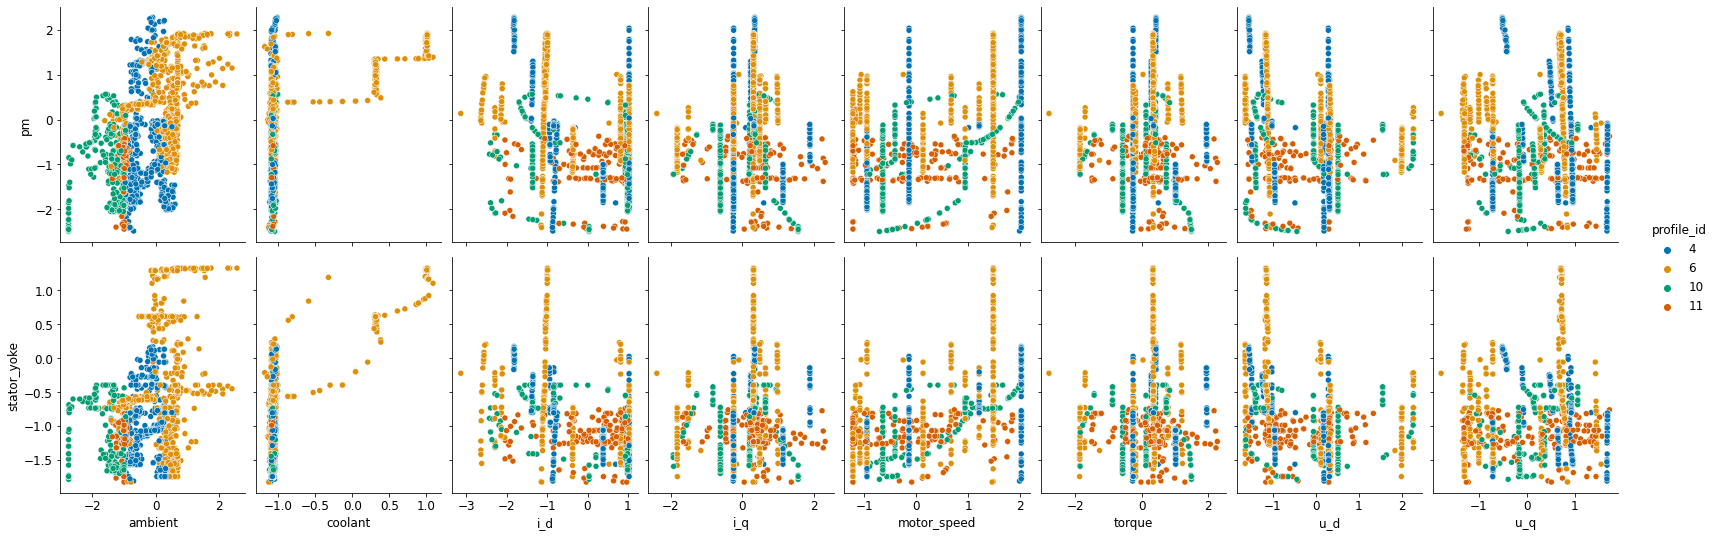

In [7]:
y_variables = ["pm","stator_yoke"]
sns.pairplot(df[(df.profile_id <= 11)].sample(2000), y_vars = y_variables,
             x_vars = df.columns.difference(y_variables + ["profile_id", "stator_tooth","stator_winding"]),
             hue = 'profile_id', palette = 'colorblind').fig.set_size_inches(24,8)

These pair plots show the relationship between the independent and dependent variables and are then colored based on the profile_id. From the looks of it there does seem to be relationships, but they are quite messy and not very linear. In addition certain profiles/tests may have been tested in different ways, and this was noted in the dataset so that should be taken into account. For example the coolant variable seems to correlate with both dependent variables although not very linearly. Logically this makes sense as coolant is meant to draw heat away from the motor to keep it cool, thus it should help indicate motor temperatures. Others appear to be quite varied and not very linear. It is important to note the difference between profiles and thus that variable should deffinitley be included(the data provider also said it is necessary).

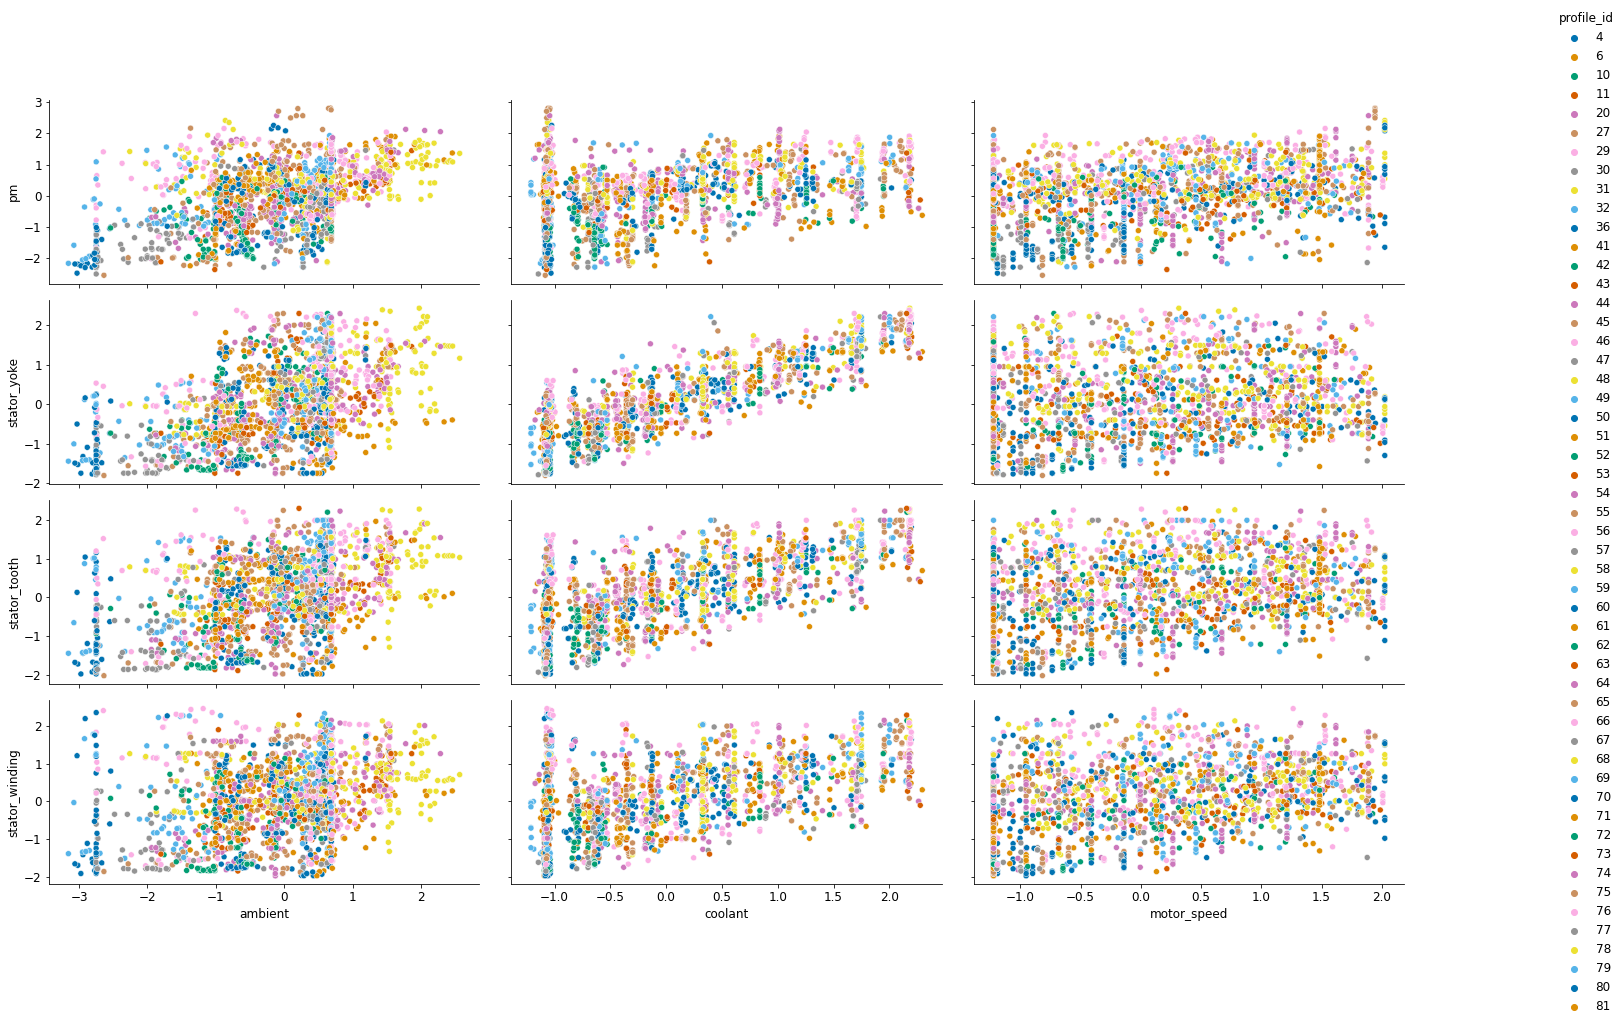

In [8]:
y_variables = ["pm","stator_yoke","stator_tooth","stator_winding"]
sns.pairplot(df.sample(2200), y_vars = y_variables,
             x_vars = ["ambient","coolant", "motor_speed"],
             hue = 'profile_id', palette = 'colorblind').fig.set_size_inches(24,12)

Using some of the correlated variables and all of the dependent variables can help show the differences between the dependent variables. When comparing the graphs they do look do be mostly similar. One notable one is the coolant and stator_yoke graph. This seems to be quite a linear relationship with a smaller variance than the rest of the coolant graphs. Could indicate that part of the motor gets better heat transfer with the coolant. Besides that, the rest seems mostly similar with some variances here or there. 

### Data Preparation

Since the dataset is very well prepared the only change needed is to fix the profile_id data. The profile_id data doesn't consistently change from one value to another which for a categorical variable is preferred. Instead, it usually goes up by one but also has some jumps by more than one, and for a categorical variable, we don't want to introduce any added complexity which could make the model perform worse.

In [74]:
procs = [Categorify]
cont,cat = cont_cat_split(df, 80, dep_var = y_variables)
print(cont,cat)

['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q'] ['profile_id']


In [75]:
splits = RandomSplitter()(range_of(df))

In [76]:
tp = TabularPandas(df, procs, cat, cont, y_names = y_variables, splits = splits)
tp["profile_id"].unique()

array([19, 52, 32, 12, 13, 24, 20, 50, 46, 40, 29,  5,  7,  9,  6, 47, 41, 11, 25,  8, 31, 48, 45,  2, 27, 42, 51, 33, 36, 35, 37, 44,  4,  1, 22, 43, 14, 30, 26, 38, 16, 28, 10, 15, 34, 21,  3, 39,
       49, 23, 18, 17], dtype=int8)

In [13]:
len(tp.train),len(tp.valid)

(798456, 199614)

Using the Fastai TabularPandas method I was able to categorify the profile_id column. I was also able to split the data in train and validation sets. Normally you also want to use test data and keep that separate, but for this notebook I will just be using validation data. Now the data should now be ready for training models.

In [14]:
save_pickle('Data/tp.pkl',tp)

In [15]:
tp = load_pickle('Data/tp.pkl')

Let's save the data, and reload it, so that it isn't necessary to reprocess all of the data. Not much of an issue now as I didn't do that many transformations, but this just speeds it up for the future.

### Model 1: Decision Tree

What is a decision tree? Well, a decision tree is exactly what it sounds like. It is a machine learning model which is a binary tree, where at each node there is a binary decision that splits the data. The learning part takes place by finding which splits on which data minimizes the error, for either classification or regression. Below I try out and display an example on the electric motor data.

In [18]:
xs,y = tp.train.xs,tp.train.y
valid_xs,valid_y = tp.valid.xs,tp.valid.y

In [19]:
m1 = DecisionTreeRegressor(max_leaf_nodes=3)
m1.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=3)

Here I split the data into train and validation sets, which is done when building models to test the performance on data that is different from the training data, to see how well the model generalizes. Then I create a decision tree with at most 3 leaf nodes, or the last decision nodes in the tree, and fit the model to the training data.

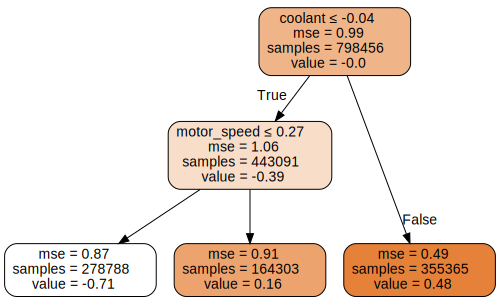

In [20]:
draw_tree(m1, xs, size=10, leaves_parallel=True, precision=2)

Above is a graph that shows visually how a decision tree works. The root node(first/top node) here splits the data where if the coolant value is less than or equal to -0.04 then it goes left(true) where it is then split by motor speed, and so on. It then trains all of the data and finds which columns have the most impact and picks the split point at the lowest error value. Then on the leaf nodes at the end of the tree is the prediction value. Now since there are only three leaf nodes that would be fine if the data had three classes to predict, but since the goal of this dataset is to predict a continuous value, decision trees need a lot of nodes.

In [21]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [22]:
m_rmse(m1, xs, y)

0.842095

In [23]:
m_rmse(m1, valid_xs, valid_y)

0.841498

In [24]:
m1 = DecisionTreeRegressor(min_samples_leaf=25)
m1.fit(xs, y)
m_rmse(m1, xs, y), m_rmse(m1, valid_xs, valid_y)

(0.116593, 0.134818)

After building and fitting the decision tree I defined two methods that help calculate the root mean squared error, which will help determine the performance of the model. In this case, the three-leaf node model gets about a 0.84 rmse which doesn't seem that great, so I tried a model that has many more nodes, and it received a test rmse of .11 and validation rmse of .13 which is an improvement.

### Model 2: Random Forest

What is a random forest? A random forest is like a decision tree, but with a few differences. A random forest works by training and ensembling multiple decision trees. When training each tree an RF uses a different random sample of the training data to train a tree independently of the other trees. The trained trees then ensemble to give the best prediction possible. [This article](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725) by Lujing Chen has a great comparison of both random forests and gradient boosting which is the next model I use.

In [25]:
def rf(xs, y, n_estimators=40, max_samples=600_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [26]:
m2 = rf(xs, y)
m_rmse(m2, xs, y), m_rmse(m2, valid_xs, valid_y)

(0.071091, 0.093953)

In [27]:
preds = np.stack([t.predict(valid_xs) for t in m2.estimators_])

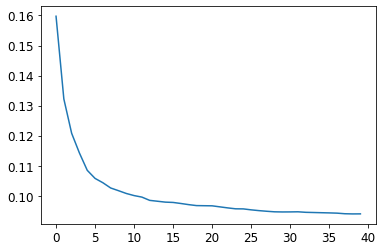

In [28]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [29]:
r_mse(m2.oob_prediction_, y)

0.097064

I then created and fit the random forest using some different hyperparameters I tried out. Also by setting n_jobs=-1 that allows the training of all trees(that the CPU can handle) to train in parallel. Then I plotted the validation rmse, and it appears to do quite well. The final values for training and validation rmse are 0.07 and 0.09, which is a significant improvement over the basic decision tree model.

In [30]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

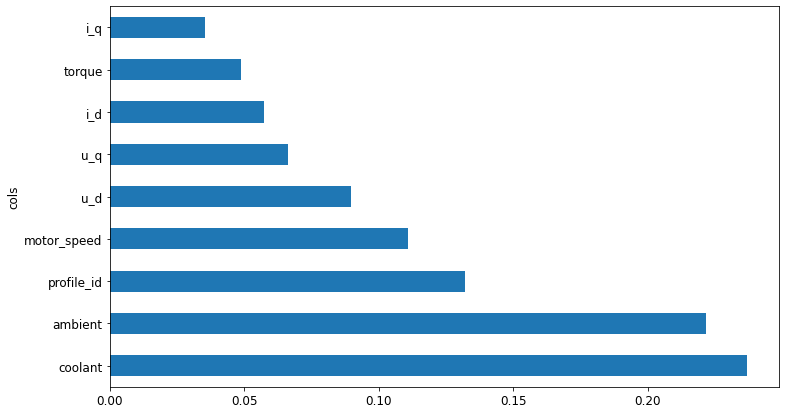

In [31]:
fi = rf_feat_importance(m2, xs)
plot_fi(fi[:30]);

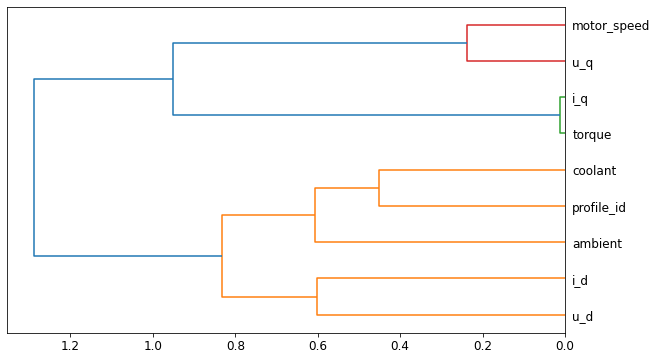

In [32]:
cluster_columns(xs)

Another important part of building machine learning models is to see how the data interacts with the model, and which features(columns in this case) are most important for prediction. This data can be retrieved as it is automatically calculated by the model. I then include two graphs that display two different aspects to feature importance. The first graph displays the overall importance of each feature, with higher being better. As I initially speculated from exploring the data, it does appear as though coolant and ambient temperature play a large role in determining the temperature of the motor. Also, profile ID is fairly important which makes sense because it describes the different tests that took place. 

Towards the bottom is i_q and torque. Logically torque probably should be towards the bottom of feature importance because in an electric motor the torque curve is relatively flat. That means no matter the temperature the torque will be the same, so there is no correlation between the two. I believe i_q is also at the bottom because it is the current of the q component of the motor, which I believe controls the amount of torque. This is reinforced by the second graph which shows how closely related two features are to one another. Thus both features probably provide little predictive information to the models.

### Model 3: XGBoost

What is XGBoost? XGBoost utilizes boosting, which is similar to a random forest but with a few key differences during training. The first is instead of independent training it is additive training. The other difference is data is not split between trees but with all training data used for each tree added. A quick analogy I think paints a simple picture is that of a pokemon trainer. A random forest would be like a trainer who has three different lower-level pokemon, each specialized in its type and excels at targeting the weaknesses of the opponent trainer. XGBoost on the other hand would then represent a single pokemon that has been fully evolved and trained to a high level. Both are two different ways of solving the same problem. And as is noted in the fastai lesson, generally the boosting model will narrowly edge out a random forest, but it has its drawbacks such as more hyperparameter tuning is usually needed. 

In [33]:
m3 = xgb.XGBRegressor(max_depth = 12, n_estimators = 150)

In [34]:
m3.fit(xs, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
m_rmse(m3, xs, y), m_rmse(m3, valid_xs, valid_y)

(0.063121, 0.094967)

After training the XGBoost model it appears roughly on par with the random forest and performs slightly better on the training data, and slightly worse but the same on validation data.

### Model 4: Neural Net

The next model I tested was a nerual network using the fastai library. Fastai is useful because it provides a tabular learner, which like the other learners in the library abstracts away a lot of the boiler plate code, but not many machine learning libraries have one dedicated to tabular data. There isn't anything fancy going on with this netowrk as it is just a dense neural net. 

In [141]:
dls = tp.dataloaders(2048)

In [142]:
y = tp.train.y
y.min(),y.max()

(-2.6319911, 2.9174562)

In [146]:
learn = tabular_learner(dls, y_range=(-6,6), layers=[200,100,50],
                        n_out=4, loss_func=mse, metrics=rmse)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0006918309954926372)

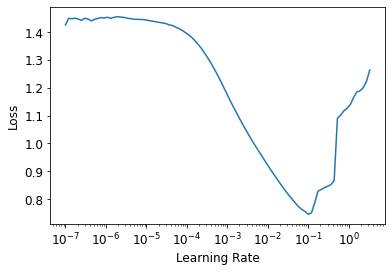

In [147]:
learn.lr_find()

In [148]:
learn.fit_one_cycle(30, 8e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.139265,0.130766,0.361615,00:08
1,0.123402,0.118719,0.344556,00:08
2,0.114603,0.111735,0.334267,00:08
3,0.109218,0.112612,0.335577,00:08
4,0.102368,0.095733,0.309408,00:08
5,0.097616,0.100569,0.317126,00:08
6,0.093039,0.094245,0.306994,00:08
7,0.088610,0.080884,0.284400,00:09
8,0.085035,0.077519,0.278423,00:08
9,0.078852,0.084001,0.289830,00:08


In [149]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.183321

In [150]:
learn.save('nn')

Path('models/nn.pth')

Here I create and train the neural network. First I need to send the data to a dataloader, which I give a batch size. Then I use the built-in tabular learner which I provide the number of dense layers and neurons for each layer. I also used mse as the loss and displayed the rmse as it trained. I then used the learning rate finder to find a learning rate that is at the highest gradient of the loss graph. I tried a lot of hyperparameters to see which are best, which is generally what is needed when training a neural network. I did get a rmse of .18 which isn't bad, but I think it would need a bit more improvement as the random forest and XGBoost models both outperformed it.

### Model 5: Ensemble

In [174]:
rf_preds = m2.predict(valid_xs)
xgb_preds = m3.predict(valid_xs)
ens_preds = (xgb_preds + rf_preds) /2

In [175]:
r_mse(ens_preds,valid_y)

0.087911

Text(0.5, 1.0, 'Actual vs Predicted')

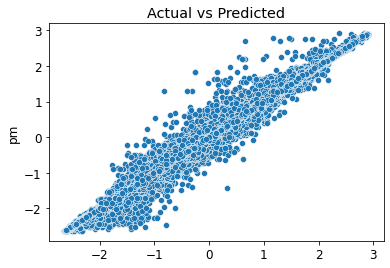

In [176]:
sns.scatterplot(x=ens_preds, y=valid_y).set_title('Actual vs Predicted')

Finally, I put together the three models to make an ensemble of the random forest and XGBoost because they performed the best. This is a way of combining models and averaging their predictions to hopefully come up with an even lower error than either individual model. As you can see by the validation rmse which does actually slighly improve and the actual vs predicted plot the models appear to do quite well at predicting the temperature of an electric motor.